## This script is used to generate plots related.

In [1]:
# import packages
import numpy as np
import pandas as pd
import os
import datetime
# define the repository path
from common_settings import  obspath, outpath, events_name, \
    obs_events, day_load_flow, hour_load_flow, conct_name, modpath
import matplotlib.pyplot as plt
import seaborn as sns

from utils.plotting import cq_line_plot

### plot the time series of discharge, concentration and C-Q

In [2]:
# plot the time series of discharge, concentration and C-Q
const_name = 'cq-NO3'
cq = pd.read_csv(outpath + const_name + '.csv')
cq.Time = pd.to_datetime(cq.Time)
for i in range(cq.shape[0]):
    cq.loc[i, 'index'] = cq.Time[i].strftime("%Y-%m-%d")
cq.set_index('Time', inplace=True, drop=False)
cols = cq.columns

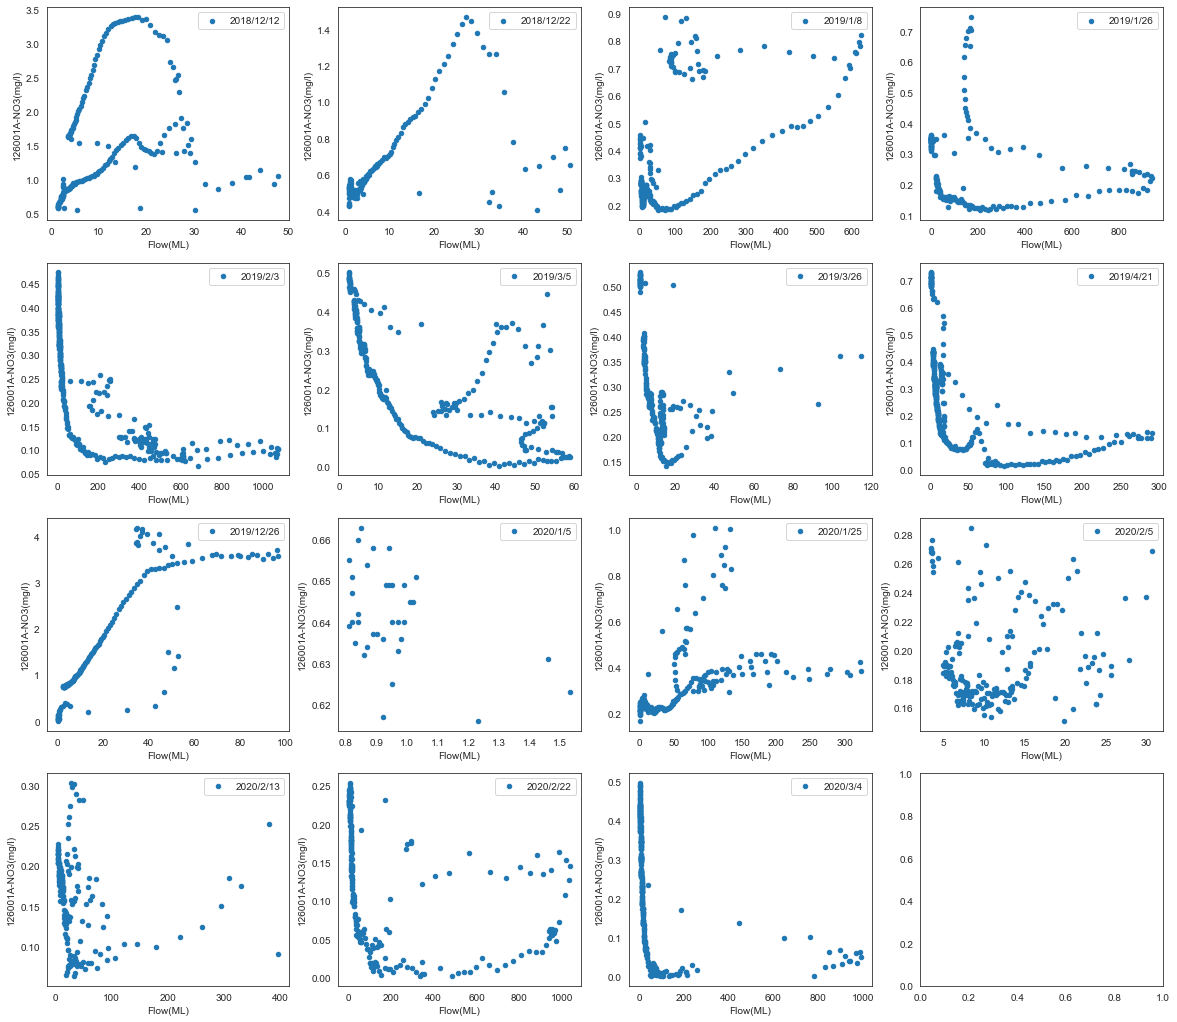

In [45]:
fig, axes = plt.subplots(4, 4, figsize=(20, 18))
k=0
for ii in obs_events.index[59:]:
    row, col = np.floor_divide(k, 4), np.mod(k, 4)
    start, end = obs_events.loc[ii, ['start', 'end']].values
    start = pd.to_datetime(start + ' 00:00:00')
    end = pd.to_datetime(end + ' 23:00:00')
    ylabel_str = 'Flow volume (ML)'
    cq_slice = cq.loc[start:end, :]
    ax_temp = cq_slice.plot(kind='scatter', x=cols[2], y=cols[1], ax=axes[row, col], legend=True)
    ax_temp.legend([obs_events.loc[ii, 'start']])
    k += 1
plt.savefig(f'{outpath}figs/obs_NO3_flow_scatter.png', format='png', dpi=400, layout='tight')

AttributeError: 'Line2D' object has no property 'ylabel'

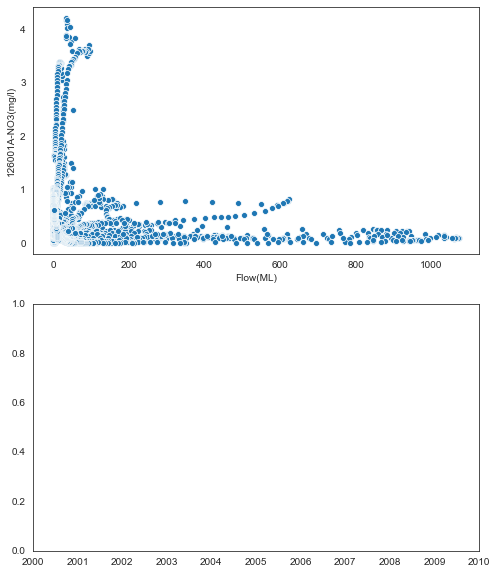

In [170]:
# Plot
sns.set_style('white')
ylabel_str = 'Discharge (ML)'
fig, axes = plt.subplots(2, figsize=(8, 10))
sns.scatterplot(data = cq, x = cols[2], y = cols[1], ax=axes[0])
cq_line_plot(cq, ylabel_str, cols, logy=False, ax=axes[1])
# plt.savefig('../../output/figs/cq-' + const_name + '-test.png', format='png', dpi=300)

In [ ]:
# Plot the data of different small time periods
time_period = ['2019-12-01', '2020-02-01']
cq_sliced = cq.loc[time_period[0]:time_period[1], :]
cq_line_plot(cq_sliced, ylabel_str, cols, logy=True)
# plt.savefig('../../output/figs/cq-' + const_name + 'mobilization-period2.png', format='png', dpi=300)

### The double-mass plot of flow and loads

In [2]:
def double_mass_line(df, xycols, fs, xlabel, ylabel, legd=None, ls=None, ax=None):
    ax = df.plot(x=xycols[0], y= xycols[1], ax=ax, ls=ls)
    ax.set_xlabel(xlabel, fontsize=fs)
    ax.set_ylabel(ylabel, fontsize=fs)
    return ax

In [4]:
fn_day = 'obs_year_cumulative_ratio_day'
df_day = pd.read_excel(f'{outpath}{fn_day}.xlsx', None);

In [3]:
fn_hour = 'obs_year_cumulative_ratio_hour'
df_hour = pd.read_excel(f'{outpath}{fn_hour}.xlsx', None);

In [11]:
fn_mod = 'mod_year_cumulative_ratio_day'
df_mod = pd.read_excel(f'{outpath}{fn_hour}.xlsx', None);

In [8]:
# read inputs (*cumulative_ratio*.xlsx)
xylabel = ['cumul_flow_ratio', 'cumul_load_ratio']
xlabel='Normalized cumulative flow volume'
ylabel='Normalized cumulative mass'
fs=16; fs_legd = 12

F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


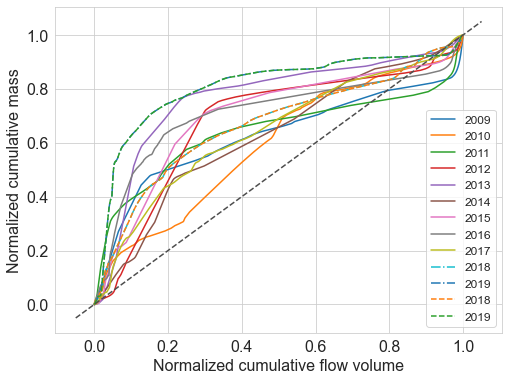

In [12]:
sns.set_style('whitegrid')
# sns.set_style("ticks", {"xtick.major.size": 14, "ytick.major.size": 14})
plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
legd = []
for _, val in df_day.items():
    legd.append(str(val.values[0][0])[0:4])
    double_mass_line(val, xylabel, fs, xlabel, ylabel, legd, ax=ax)
for _, val in df_hour.items():
    legd.append(str(val.values[0][0])[0:4])
    double_mass_line(val, xylabel, fs, xlabel, ylabel, legd, ax=ax, ls='-.')
for _, val in df_mod.items():    
    legd.append(str(val.values[0][0])[0:4])
    double_mass_line(val, xylabel, fs, xlabel, ylabel, legd, ax=ax, ls='--')
ax.legend(legd, fontsize=fs_legd);
ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c=".3")
ax.set_yticklabels(np.round(ax.get_yticks(), 2), size = 16);
ax.set_xticklabels(np.round(ax.get_xticks(), 2), size = 16);
# plt.savefig(f'{outpath}figs/{fn_day}_hour.png', format='png', dpi=400)

### Plot Event Mean Concentration (EMC)

In [53]:
# import EMC and tranform into a matrix
emc = pd.read_csv(f'{outpath}obs_storm_event.csv', index_col='ID')
# emc = pd.read_csv(f'{outpath}mod_NO3_flow.csv', index_col='ID')

In [54]:
emc_matrix = {year: [] for year in range(2009, 2020)}
# emc_matrix = {year: [] for year in range(2009, 2014)}
emc.start = pd.to_datetime(emc.start)

In [55]:
for ii in emc.index:
    if emc.start[ii].month < 7:
        emc_matrix[emc.start[ii].year - 1].append(emc.loc[ii, 'event_load_coefficients'])
    else:
        emc_matrix[emc.start[ii].year].append(emc.loc[ii, 'event_load_coefficients'])
# convert dict into a dataframe
df_fillna = pd.DataFrame(index=np.arange(1, 12), columns=emc_matrix.keys())
for key, val in emc_matrix.items():
    df_fillna.loc[0:len(val), key] = val
df_fillna.fillna(0, inplace=True)

In [56]:
# creat a mask
mask = np.zeros_like(df_fillna.values)
mask[df_fillna == 0] = True

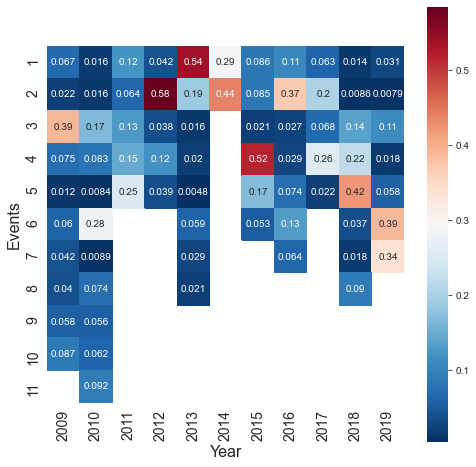

In [57]:
sns.set_context({"figure.figsize":(8,8)})
sns.axes_style("white")
ax = sns.heatmap(data=np.array(df_fillna.values),square=True, annot=True, mask=mask, 
            xticklabels=df_fillna.columns, yticklabels= df_fillna.index,cmap="RdBu_r") 
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Events', fontsize=16)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14);
plt.savefig(f'{outpath}figs/obs_event_load_coefficients.png', format='png', dpi=400)